C:\Users\anush\AppData\Local\Temp\ipykernel_24052\3571520573.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Jerk'].fillna(0, inplace=True)


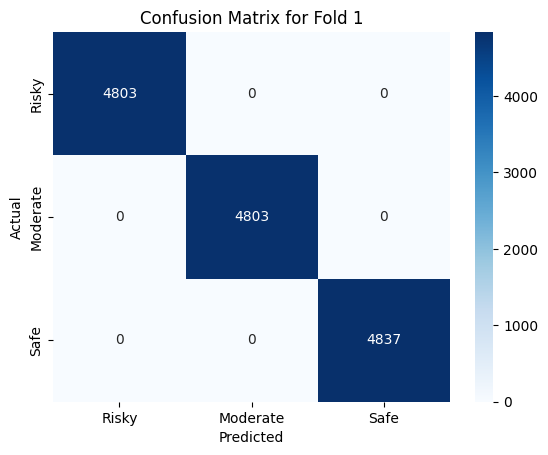

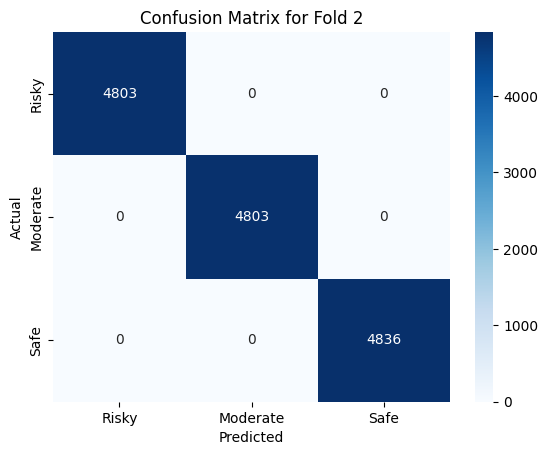

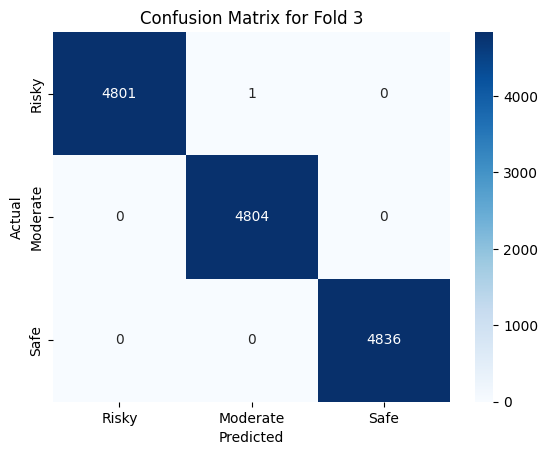

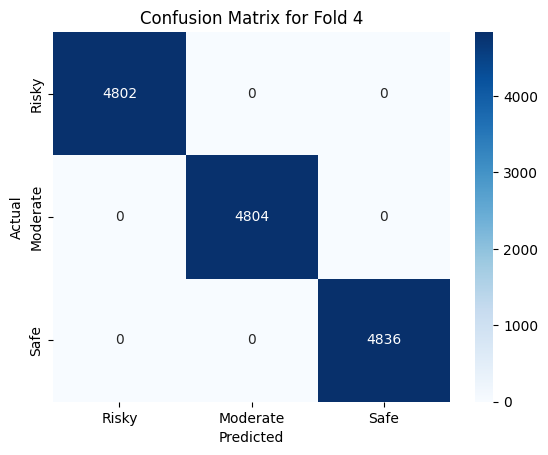

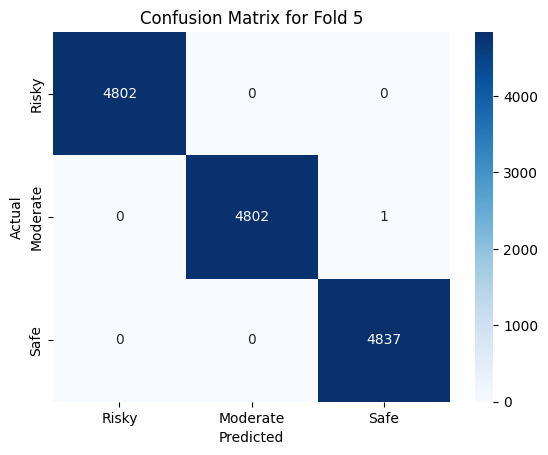


Average Validation Accuracy: 1.0000
Test Set Accuracy: 1.0000


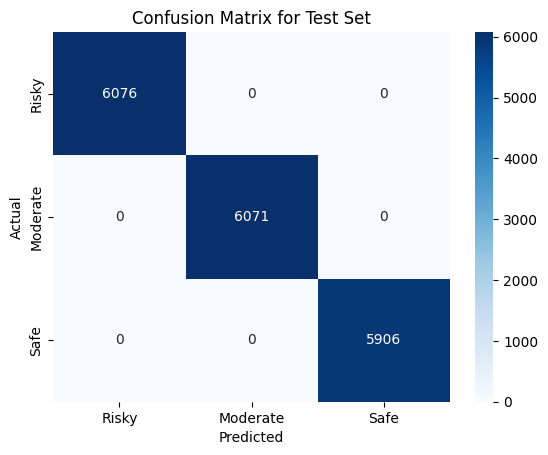

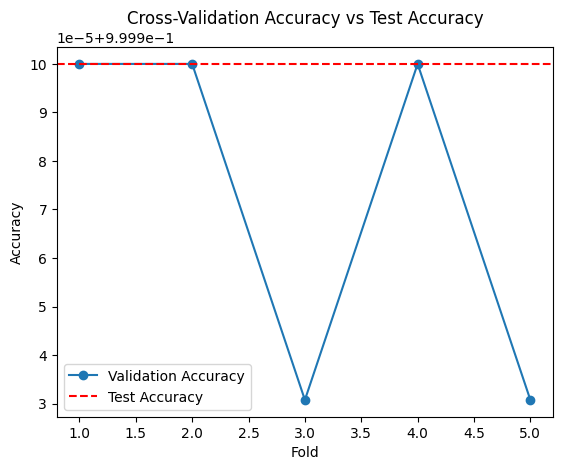

In [1]:
import os
import pandas as pd
import numpy as np
from haversine import haversine, Unit
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Load sensitive locations
sensitive_locations = pd.read_csv('../data/sensitive_location.csv')

def analyze_driving_data(df):
    """Analyzes driving data based on absolute metrics."""
    # Define thresholds
    speed_limit = 30  # Speed limit in km/h
    harsh_acceleration_threshold = 3.0  # Harsh acceleration in m/s^2
    harsh_braking_threshold = -3.0  # Harsh braking in m/s^2
    jerk_threshold = 5.0  # Jerk threshold in m/s^3
    heading_change_threshold = 30.0  # Heading change threshold in degrees

    # Initialize columns
    df['Jerk'] = df['Acceleration'].diff() / df['TimeStep'].diff()  # Jerk in m/s^3
    df['Jerk'].fillna(0, inplace=True)
    df['Driving_Score'] = 100  # Start with maximum score

    # Calculate penalties based on thresholds
    df['Speed_Violation'] = np.where(df['Speed'] > speed_limit, (df['Speed'] - speed_limit) * 2, 0)
    df['Harsh_Acceleration'] = np.where(df['Acceleration'] > harsh_acceleration_threshold, 
                                         (df['Acceleration'] - harsh_acceleration_threshold) * 2, 0)
    df['Harsh_Braking'] = np.where(df['Acceleration'] < harsh_braking_threshold, 
                                    (harsh_braking_threshold - df['Acceleration']) * 2, 0)
    df['High_Jerk'] = np.where(abs(df['Jerk']) > jerk_threshold, 
                               abs(df['Jerk'] - jerk_threshold) * 2, 0)
    df['High_Heading_Change'] = np.where(abs(df['HeadingChange']) > heading_change_threshold, 
                                         abs(df['HeadingChange'] - heading_change_threshold) * 2, 0)

    # Deduct points for violations
    df['Driving_Score'] -= df[['Speed_Violation', 'Harsh_Acceleration', 
                                'Harsh_Braking', 'High_Jerk', 'High_Heading_Change']].sum(axis=1)

    # Sensitive location violations
    df['Sensitive_Area_Violation'] = 0
    for index, row in df.iterrows():
        driver_location = (row['Latitude'], row['Longitude'])
        for _, loc in sensitive_locations.iterrows():
            sensitive_location = (loc['Latitude'], loc['Longitude'])
            distance = haversine(driver_location, sensitive_location, unit=Unit.METERS)
            if distance <= 300 and row['Speed'] > (speed_limit * 1000 / 3600):  # Speed limit in m/s
                df.at[index, 'Sensitive_Area_Violation'] = 1
                break
    df['Driving_Score'] -= df['Sensitive_Area_Violation'] * 5

    # Categorize driving behavior
    def categorize_driving(score):
        if score >= 80:
            return 'Safe'
        elif 60 <= score < 80:
            return 'Moderate'
        else:
            return 'Risky'

    df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving)
    return df

# Load driving data
driving_data = pd.read_csv('../data/driving_data.csv')

# Analyze driving data
analyzed_data = analyze_driving_data(driving_data)
analyzed_data.to_csv('../data/analyzed_driving_data.csv', index=False)

# Prepare data for model training
features = ['Speed', 'Acceleration', 'Jerk', 'High_Jerk', 'Speed_Violation', 
            'Harsh_Acceleration', 'Harsh_Braking', 'Sensitive_Area_Violation', 'High_Heading_Change']
target = 'Driving_Category'

X = analyzed_data[features]
y = analyzed_data[target].map({'Safe': 2, 'Moderate': 1, 'Risky': 0})

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights_dict = dict(enumerate(class_weights))

# Models
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)
gbc_model = GradientBoostingClassifier(random_state=42)

# Ensemble Model
ensemble_model = VotingClassifier(estimators=[('rf', rf_model), ('gbc', gbc_model)], voting='soft')

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), start=1):
    # Convert y_train to numpy for indexing compatibility
    y_train_np = y_train.to_numpy()
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train_np[train_idx], y_train_np[val_idx]

    # Train ensemble model
    ensemble_model.fit(X_train_fold, y_train_fold)

    # Validate
    y_val_pred = ensemble_model.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    accuracy_scores.append(accuracy)

    # Confusion Matrix
    cm = confusion_matrix(y_val_fold, y_val_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], yticklabels=['Risky', 'Moderate', 'Safe'])
    plt.title(f'Confusion Matrix for Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Average Validation Accuracy
print(f"\nAverage Validation Accuracy: {np.mean(accuracy_scores):.4f}")

# Test Set Evaluation
y_test_pred = ensemble_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy:.4f}")

# Confusion Matrix for Test Set
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure()
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Risky', 'Moderate', 'Safe'], yticklabels=['Risky', 'Moderate', 'Safe'])
plt.title('Confusion Matrix for Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Cross-Validation vs Test Accuracy Plot
plt.figure()
plt.plot(range(1, 6), accuracy_scores, marker='o', label='Validation Accuracy')
plt.axhline(test_accuracy, color='red', linestyle='--', label='Test Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy vs Test Accuracy')
plt.legend()
plt.show()

